Risk–Neutral Pricing of Bonds:
---------------------------------
USD Bond (theory): 0.7788
USD Bond (MC):     0.7793
EUR Bond (theory, in USD): 0.9065
EUR Bond (MC, in USD):     0.7793

Delta of EUR Bond Price with respect to S0: 0.7793


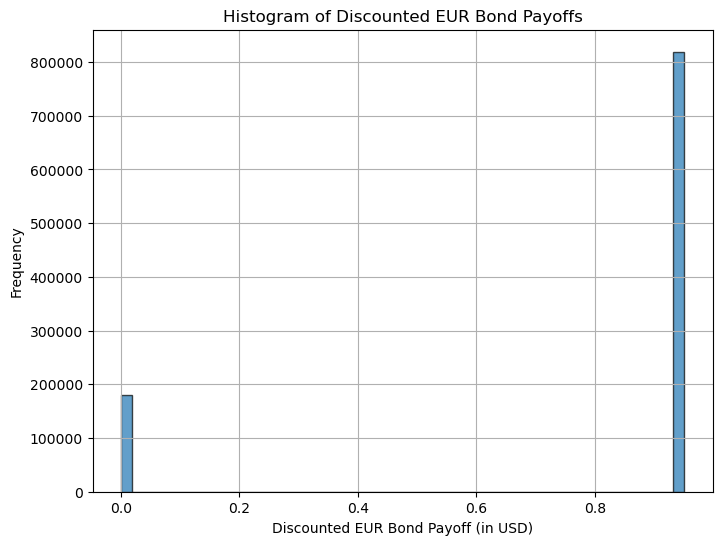

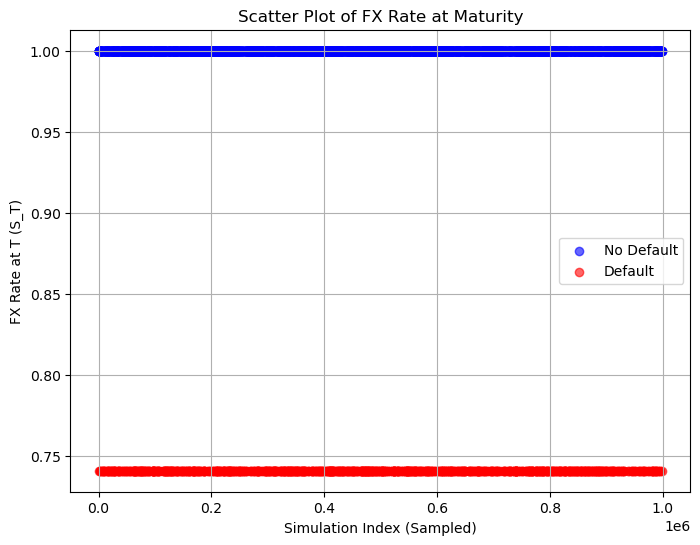

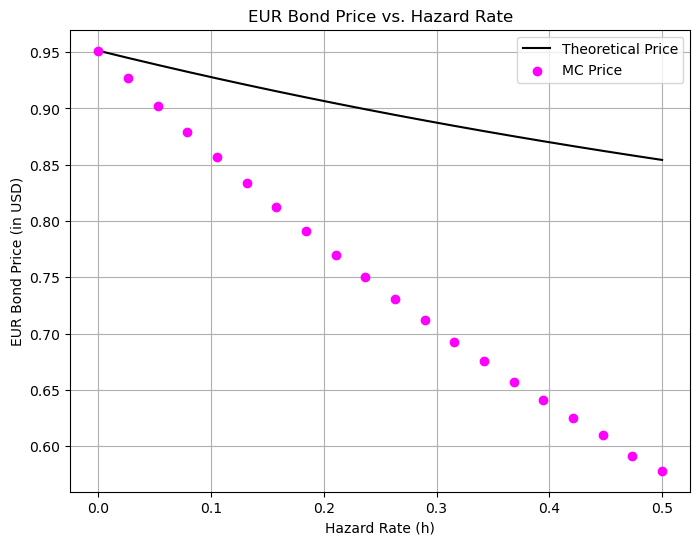

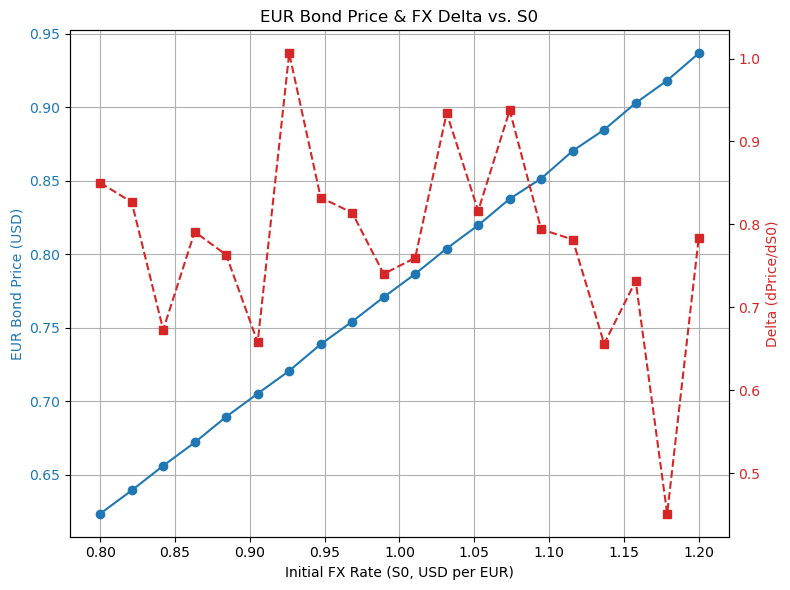

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Simulation Functions
# ---------------------------

def simulate_eur_bond_price(num_simulations, T, h, J, S0, r=0.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    # Generate uniform random numbers for each simulation
    U = np.random.rand(num_simulations)
    # Default occurs if U is less than the probability of default (1 - exp(-h*T))
    default = U < (1 - np.exp(-h * T))
    
    # FX rate at T: S_T = S0 if no default; S0*exp(J) if default
    S_T = np.where(default, S0 * np.exp(J), S0)
    
    # The bond’s payoff in EUR is 1 if no default, 0 if default.
    # Convert payoff to USD using S_T.
    payoff = np.where(default, 0.0, S_T)
    
    # Discount the payoff back to time 0
    discount_factor = np.exp(-r * T)
    price = discount_factor * np.mean(payoff)
    return price

def simulate_usd_bond_price(num_simulations, T, h, r=0.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    U = np.random.rand(num_simulations)
    no_default = U >= (1 - np.exp(-h * T))
    payoff = np.where(no_default, 1.0, 0.0)
    
    discount_factor = np.exp(-r * T)
    price = discount_factor * np.mean(payoff)
    return price

def compute_delta_eur_bond(num_simulations, T, h, J, S0, r=0.0, dS=0.01, seed=None):
    price_up = simulate_eur_bond_price(num_simulations, T, h, J, S0 + dS, r, seed)
    price_down = simulate_eur_bond_price(num_simulations, T, h, J, S0 - dS, r, seed)
    delta = (price_up - price_down) / (2 * dS)
    return delta

def simulate_fx_default(num_simulations, T, h, J, S0, seed=None):
    # Simulate the FX rate at maturity T and default indicators for each simulation.
    if seed is not None:
        np.random.seed(seed)
    U = np.random.rand(num_simulations)
    default = U < (1 - np.exp(-h * T))
    S_T = np.where(default, S0 * np.exp(J), S0)
    return S_T, default

# ---------------------------
# Visualization Functions
# ---------------------------

def plot_payoff_histogram(payoffs, r, T):
    discount_factor = np.exp(-r * T)
    discounted_payoffs = payoffs * discount_factor
    plt.figure(figsize=(8, 6))
    plt.hist(discounted_payoffs, bins=50, edgecolor='k', alpha=0.7)
    plt.xlabel("Discounted EUR Bond Payoff (in USD)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Discounted EUR Bond Payoffs")
    plt.grid(True)
    plt.show()

def plot_fx_scatter(S_T, default):
    num_points = len(S_T)
    # Sample at most 5000 points for clarity
    sample_size = min(5000, num_points)
    indices = np.random.choice(num_points, sample_size, replace=False)
    sampled_S_T = S_T[indices]
    sampled_default = default[indices]
    
    plt.figure(figsize=(8, 6))
    # Plot non-default points in blue, default points in red.
    plt.scatter(indices[~sampled_default], sampled_S_T[~sampled_default],
                color='blue', alpha=0.6, label='No Default')
    plt.scatter(indices[sampled_default], sampled_S_T[sampled_default],
                color='red', alpha=0.6, label='Default')
    plt.xlabel("Simulation Index (Sampled)")
    plt.ylabel("FX Rate at T (S_T)")
    plt.title("Scatter Plot of FX Rate at Maturity")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_price_vs_hazard(T, J, S0, r, num_simulations):
    # For a range of hazard rates, plot the theoretical vs. Monte Carlo price of the EUR bond.
    h_vals = np.linspace(0.0, 0.5, 20)
    P_theory = []
    P_MC = []
    for h_val in h_vals:
        # Theoretical EUR bond price (in USD)
        p_theory = np.exp(-r * T) * S0 * (np.exp(-h_val * T) + np.exp(J) * (1 - np.exp(-h_val * T)))
        P_theory.append(p_theory)
        # Monte Carlo price
        p_mc = simulate_eur_bond_price(num_simulations, T, h_val, J, S0, r)
        P_MC.append(p_mc)
    
    plt.figure(figsize=(8, 6))
    plt.plot(h_vals, P_theory, 'k-', label='Theoretical Price')
    plt.scatter(h_vals, P_MC, color='magenta', label='MC Price', zorder=5)
    plt.xlabel("Hazard Rate (h)")
    plt.ylabel("EUR Bond Price (in USD)")
    plt.title("EUR Bond Price vs. Hazard Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_sensitivity_vs_S0(T, h, J, r, num_simulations):
    # For a range of initial FX rates S0, compute the EUR bond price and its delta.
    S0_vals = np.linspace(0.8, 1.2, 20)
    prices = []
    deltas = []
    for S0_val in S0_vals:
        price = simulate_eur_bond_price(num_simulations, T, h, J, S0_val, r)
        delta = compute_delta_eur_bond(num_simulations, T, h, J, S0_val, r, dS=0.005)
        prices.append(price)
        deltas.append(delta)
    
    fig, ax1 = plt.subplots(figsize=(8, 6))

    color = 'tab:blue'
    ax1.set_xlabel("Initial FX Rate (S0, USD per EUR)")
    ax1.set_ylabel("EUR Bond Price (USD)", color=color)
    ax1.plot(S0_vals, prices, 'o-', color=color, label="Price")
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    ax2 = ax1.twinx()  # share the same x-axis
    color = 'tab:red'
    ax2.set_ylabel("Delta (dPrice/dS0)", color=color)
    ax2.plot(S0_vals, deltas, 's--', color=color, label="Delta")
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("EUR Bond Price & FX Delta vs. S0")
    fig.tight_layout()
    plt.show()

# ---------------------------
# Main Analysis & Plots
# ---------------------------

def main():
    # ---------------------------
    # Model Parameters
    # ---------------------------
    T = 1.0          # Maturity in years
    h = 0.2          # Hazard rate (default intensity)
    J = -0.3         # FX jump on default (log jump; exp(J) ~ 0.7408, ~26% depreciation)
    S0 = 1.0         # Initial FX rate (USD per EUR)
    r = 0.05         # Domestic risk–free rate (annual)
    num_simulations = 1_000_000
    seed = 42

    # ---------------------------
    # Theoretical Prices
    # ---------------------------
    P_USD_theory = np.exp(-r * T) * np.exp(-h * T)
    P_EUR_theory = np.exp(-r * T) * S0 * (np.exp(-h * T) + np.exp(J) * (1 - np.exp(-h * T)))
    
    # ---------------------------
    # Monte Carlo Pricing
    # ---------------------------
    P_USD_mc = simulate_usd_bond_price(num_simulations, T, h, r, seed)
    P_EUR_mc = simulate_eur_bond_price(num_simulations, T, h, J, S0, r, seed)
    
    print("Risk–Neutral Pricing of Bonds:")
    print("---------------------------------")
    print("USD Bond (theory): {:.4f}".format(P_USD_theory))
    print("USD Bond (MC):     {:.4f}".format(P_USD_mc))
    print("EUR Bond (theory, in USD): {:.4f}".format(P_EUR_theory))
    print("EUR Bond (MC, in USD):     {:.4f}".format(P_EUR_mc))
    
    # ---------------------------
    # Compute FX Delta for the EUR Bond
    # ---------------------------
    delta = compute_delta_eur_bond(num_simulations, T, h, J, S0, r, dS=0.01, seed=seed)
    print("\nDelta of EUR Bond Price with respect to S0: {:.4f}".format(delta))
    
    # ---------------------------
    # Extra Visualizations
    # ---------------------------
    
    # (A) Histogram of Discounted EUR Bond Payoffs (in USD)
    S_T, default = simulate_fx_default(num_simulations, T, h, J, S0, seed)
    payoffs = np.where(default, 0.0, S_T)  # Payoff: 0 if default, S_T if no default
    plot_payoff_histogram(payoffs, r, T)
    
    # (B) Scatter Plot of FX Rates at Maturity
    plot_fx_scatter(S_T, default)
    
    # (C) EUR Bond Price vs. Hazard Rate (Theoretical vs. MC)
    plot_price_vs_hazard(T, J, S0, r, num_simulations=200_000)  # Fewer simulations for speed
    
    # (D) Sensitivity Analysis: Price and Delta vs. S0
    plot_sensitivity_vs_S0(T, h, J, r, num_simulations=200_000)  # Fewer simulations for speed

if __name__ == "__main__":
    main()
